In [1]:
# python libraries
import os
import sys
import dataclasses
from datetime import datetime
from pathlib import Path
from operator import methodcaller
from collections import OrderedDict
from dataclasses import dataclass
from typing import (
    List,
    Tuple,
    Dict,
    Any,
    Mapping,
    Callable
)
from enum import Enum
# adding the path
if not str(Path(os.getcwd()).parent) in sys.path:
    sys.path.append(str(Path(os.getcwd()).parent))

# numpy
import numpy as np

# torch
import torch
import torchvision
from torch import nn
from torchvision import (
    transforms,
    datasets
    )
from torch.utils.data import DataLoader

try:
    from torchmetrics import Accuracy
except:
    print(f"[INFO] Installing the torchmetrics")
    %pip install torchmetrics
    from torchmetrics import Accuracy

try:
    import torchinfo
except:
    print(f"[INFO] Installing the torchinfo")
    %pip install torchinfo
    import torchinfo

# helper function
try:
    import my_helper as helper
except:
    print("[INFO] Downloading the helper function from github")
    import requests
    response = requests.get("https://raw.githubusercontent.com/Lashi0812/PyTorch2/master/my_helper.py")
    with open("my_helper.py" ,"wb") as f:
        f.write(response.content)
    import my_helper as helper

[INFO] Installing the torchmetrics
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 4.9 MB/s eta 0:00:00
[INFO] Installing the torchinfo
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[INFO] Downloading the helper function from github


In [2]:
## Connect Persistence memory
try :
    from google.colab import drive

    # Paths
    DRIVE_PATH = Path("/content/drive")
    MODEL_SAVE_PATH = Path("/content/drive/Othercomputers/My PC/drive/models")

    # mount drive
    drive.mount(str(DRIVE_PATH))
except:
    MODEL_SAVE_PATH = Path(os.getcwd())/"models"

Mounted at /content/drive


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Network in Network

In [4]:
@dataclass(eq=False)
class NiN(helper.Classifier):
    lr:int = 0.01
    num_classes:int = 10

    def __post_init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.nin_block(96,kernel=11,stride=4,padding=0),
            nn.MaxPool2d(kernel_size=3,stride=2),
            self.nin_block(256,kernel=5,stride=1,padding=2),
            nn.MaxPool2d(kernel_size=3,stride=2),
            self.nin_block(384,kernel=3,stride=1,padding=1),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Dropout(0.5),
            self.nin_block(self.num_classes,kernel=3,stride=1,padding=1),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
        )


    @staticmethod
    def nin_block(out_channels,kernel,stride,padding):
        return nn.Sequential(
            nn.LazyConv2d(out_channels,kernel_size=kernel,stride=stride,padding=padding),nn.ReLU(),
            # this two layer will do job of FC , this will  increase the non linearity.
            nn.LazyConv2d(out_channels,kernel_size=1),nn.ReLU(),
            nn.LazyConv2d(out_channels,kernel_size=1),nn.ReLU()          
        )
    @staticmethod
    def init_nin(module):
        if isinstance(module,(nn.Linear,nn.Conv2d)):
            nn.init.kaiming_normal_(module.weight)

In [5]:
NiN().layer_summary((1,1,224,224))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential      output shape :(1, 96, 54, 54)
MaxPool2d       output shape :(1, 96, 26, 26)
Sequential      output shape :(1, 256, 26, 26)
MaxPool2d       output shape :(1, 256, 12, 12)
Sequential      output shape :(1, 384, 12, 12)
MaxPool2d       output shape :(1, 384, 5, 5)
Dropout         output shape :(1, 384, 5, 5)
Sequential      output shape :(1, 10, 5, 5)
AdaptiveAvgPool2d output shape :(1, 10, 1, 1)
Flatten         output shape :(1, 10)


In [6]:
torchinfo.summary(NiN(),input_size=(1,224,224)  ,  col_width=14,
    col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
    row_settings=["var_names"],
)

Layer (type (var_name))                  Kernel Shape   Output Shape   Param #        Mult-Adds
NiN (NiN)                                --             [10, 1]        --             --
├─Sequential (net)                       --             [10, 1]        --             --
│    └─Sequential (0)                    --             [96, 54, 54]   --             --
│    │    └─Conv2d (0)                   [11, 11]       [96, 54, 54]   11,712         60,715,008
│    │    └─ReLU (1)                     --             [96, 54, 54]   --             --
│    │    └─Conv2d (2)                   [1, 1]         [96, 54, 54]   9,312          48,273,408
│    │    └─ReLU (3)                     --             [96, 54, 54]   --             --
│    │    └─Conv2d (4)                   [1, 1]         [96, 54, 54]   9,312          48,273,408
│    │    └─ReLU (5)                     --             [96, 54, 54]   --             --
│    └─MaxPool2d (1)                     3              [96, 26, 26]   --      

The total parameter size is reduce compare to pervious architecture like AlexNet ,VGG , since they had the FC layer 

# Training

In [7]:
nin_model = NiN(lr=0.01)
data = helper.FashionMNIST(batch_size=128,resize=(224,224))
nin_model.apply_init([(next(iter(data.train_dataloader())))[0]],nin_model.init_nin)
nin_trainer =helper.Trainer(max_epochs=10,model_save_path=MODEL_SAVE_PATH)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Training the model in cuda


  0%|          | 0/10 [00:00<?, ?it/s]

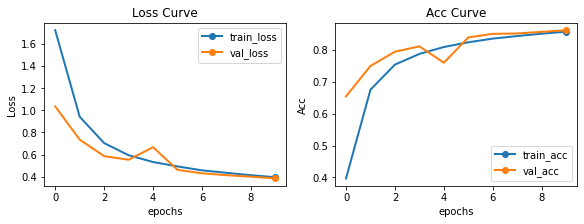

[Info] Saving the model at /content/drive/Othercomputers/My PC/drive/models/2023-02-05/NiN-060646.pth


In [8]:
nin_trainer.fit(nin_model,data)

# Why 1x1 conv is same as FC layer ?

This concept is introduce in the  NiN paper.

[Refer this for the below example](https://sebastianraschka.com/faq/docs/fc-to-conv.html)

![image.png](attachment:image.png)

In [9]:
#? take the random tensor of shape [1,1,2,2] ---> [b,c,h,w]
inputs = torch.rand(size=(1,1,2,2),dtype=torch.float)
inputs

tensor([[[[0.8989, 0.8290],
          [0.4802, 0.0786]]]])

## Fully connected layer

In [10]:
# consider we have 4 input neuron and 2 output neuron
weights = torch.rand(size=(2,4),dtype=torch.float)
bias = torch.rand(size=(2,),dtype=torch.float)

In [11]:
fc = nn.Linear(in_features=4,out_features=2)

In [12]:
# fix the weights 
fc.weight.data = weights
fc.bias.data = bias

In [13]:
# pass the input to FC layer and then pass them to relu activation units
torch.relu(fc(nn.Flatten()(inputs)))

tensor([[2.9685, 1.3028]], grad_fn=<ReluBackward0>)

## 1x1 Conv

In [14]:
conv = nn.Conv2d(in_channels=4,out_channels=2,kernel_size=1,stride=1,padding=0)
#? kernel shape [out_chan,in_chan,1,1]
conv.weight.data = weights.reshape((2,4,1,1))
conv.bias.data = bias

In [15]:
torch.relu(conv(inputs.reshape(1,4,1,1)))

tensor([[[[2.9685]],

         [[1.3028]]]], grad_fn=<ReluBackward0>)

Output of the 1x1 conv is same as the FC layer,

# Visual some output

In [16]:
# load the trained model
nin_model  = NiN().to(device)
nin_model.load_state_dict(torch.load(nin_trainer.save_path,map_location=device))

<All keys matched successfully>

In [17]:
for k,v in nin_model.named_parameters():
    print(k,tuple(v.shape))

net.0.0.weight (96, 1, 11, 11)
net.0.0.bias (96,)
net.0.2.weight (96, 96, 1, 1)
net.0.2.bias (96,)
net.0.4.weight (96, 96, 1, 1)
net.0.4.bias (96,)
net.2.0.weight (256, 96, 5, 5)
net.2.0.bias (256,)
net.2.2.weight (256, 256, 1, 1)
net.2.2.bias (256,)
net.2.4.weight (256, 256, 1, 1)
net.2.4.bias (256,)
net.4.0.weight (384, 256, 3, 3)
net.4.0.bias (384,)
net.4.2.weight (384, 384, 1, 1)
net.4.2.bias (384,)
net.4.4.weight (384, 384, 1, 1)
net.4.4.bias (384,)
net.7.0.weight (10, 384, 3, 3)
net.7.0.bias (10,)
net.7.2.weight (10, 10, 1, 1)
net.7.2.bias (10,)
net.7.4.weight (10, 10, 1, 1)
net.7.4.bias (10,)


In [18]:
X,y  = next(iter(data.train_dataloader()))
X.shape,y.shape

(torch.Size([128, 1, 224, 224]), torch.Size([128]))

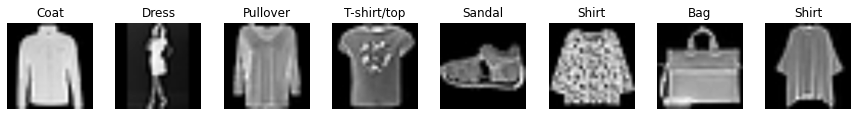

In [19]:
data.visualize(next(iter(data.train_dataloader())))

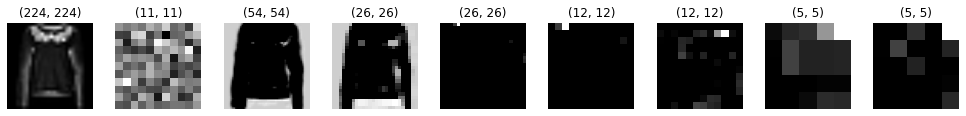

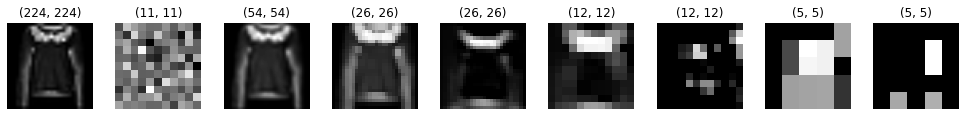

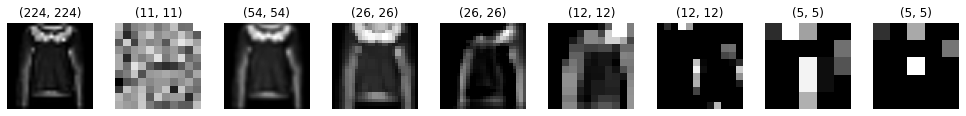

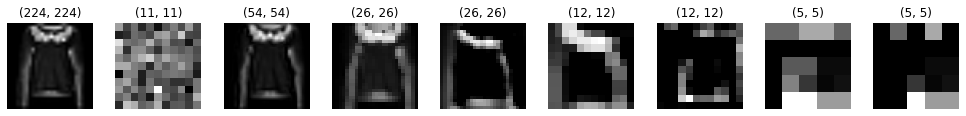

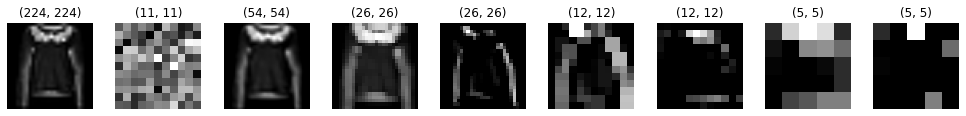

In [21]:
helper.visual_block(X[0],nin_model,1,8,0,nin_trainer)

# Some Experiment

## Changing the number of 1x1 conv in each nin block.
1. Increase from two to three.
2. Decrease from two to one.

In [22]:
@dataclass(eq=False)
class NiNWithOne(helper.Classifier):
    """
    Output channel number is taken from the sequence [A133572 Row sums of triangle A133571]
    1, 4, 6, 16, 24, 64, 96, 256, 384, 1024......
    refer : https://oeis.org/A133572
    """
    lr:int = 0.01
    num_classes:int = 10
    

    def __post_init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.nin_block(96,11,4,0),
            nn.MaxPool2d(kernel_size=3,stride=2),
            self.nin_block(256,kernel=5,stride=1,padding=2),
            nn.MaxPool2d(kernel_size=3,stride=2),
            self.nin_block(384,3,1,2),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Dropout(0.5),
            self.nin_block(self.num_classes,kernel=3,stride=1,padding=1),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
        )

    @staticmethod
    def nin_block(out_channels,kernel,stride,padding):
        return nn.Sequential(
            nn.LazyConv2d(out_channels,kernel_size=kernel,stride=stride,padding=padding),nn.ReLU(),
            # modified to have one 1x1 conv
            nn.LazyConv2d(out_channels,kernel_size=1),nn.ReLU()
        )

    @staticmethod
    def init_nin(module):
        if isinstance(module,(nn.Linear,nn.Conv2d)):
            nn.init.kaiming_normal_(module.weight)

In [23]:
NiNWithOne().layer_summary((1,1,224,224))

Sequential      output shape :(1, 96, 54, 54)
MaxPool2d       output shape :(1, 96, 26, 26)
Sequential      output shape :(1, 256, 26, 26)
MaxPool2d       output shape :(1, 256, 12, 12)
Sequential      output shape :(1, 384, 14, 14)
MaxPool2d       output shape :(1, 384, 6, 6)
Dropout         output shape :(1, 384, 6, 6)
Sequential      output shape :(1, 10, 6, 6)
AdaptiveAvgPool2d output shape :(1, 10, 1, 1)
Flatten         output shape :(1, 10)


In [24]:
torchinfo.summary(NiNWithOne(),input_size=(1,224,224)  ,  col_width=14,
    col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
    row_settings=["var_names"],
)

Layer (type (var_name))                  Kernel Shape   Output Shape   Param #        Mult-Adds
NiNWithOne (NiNWithOne)                  --             [10, 1]        --             --
├─Sequential (net)                       --             [10, 1]        --             --
│    └─Sequential (0)                    --             [96, 54, 54]   --             --
│    │    └─Conv2d (0)                   [11, 11]       [96, 54, 54]   11,712         60,715,008
│    │    └─ReLU (1)                     --             [96, 54, 54]   --             --
│    │    └─Conv2d (2)                   [1, 1]         [96, 54, 54]   9,312          48,273,408
│    │    └─ReLU (3)                     --             [96, 54, 54]   --             --
│    └─MaxPool2d (1)                     3              [96, 26, 26]   --             --
│    └─Sequential (2)                    --             [256, 26, 26]  --             --
│    │    └─Conv2d (0)                   [5, 5]         [256, 26, 26]  614,656        4

### Transferring the learned weight for nin_model to nin_with_one

In [25]:
nin_with_one =  NiNWithOne().to(device)

In [26]:
for k,v in nin_with_one.named_parameters():
    print(k,v)

net.0.0.weight <UninitializedParameter>
net.0.0.bias <UninitializedParameter>
net.0.2.weight <UninitializedParameter>
net.0.2.bias <UninitializedParameter>
net.2.0.weight <UninitializedParameter>
net.2.0.bias <UninitializedParameter>
net.2.2.weight <UninitializedParameter>
net.2.2.bias <UninitializedParameter>
net.4.0.weight <UninitializedParameter>
net.4.0.bias <UninitializedParameter>
net.4.2.weight <UninitializedParameter>
net.4.2.bias <UninitializedParameter>
net.7.0.weight <UninitializedParameter>
net.7.0.bias <UninitializedParameter>
net.7.2.weight <UninitializedParameter>
net.7.2.bias <UninitializedParameter>


In [27]:
nin_with_one.apply_init([next(iter(data.train_dataloader()))[0].to(device)],nin_with_one.init_nin)

In [28]:
for k,v in nin_with_one.named_parameters():
    print(k,v.shape,torch.mean(v).item())

net.0.0.weight torch.Size([96, 1, 11, 11]) -0.002286304719746113
net.0.0.bias torch.Size([96]) -0.0020106325391680002
net.0.2.weight torch.Size([96, 96, 1, 1]) 0.0003214972384739667
net.0.2.bias torch.Size([96]) 0.0009639430791139603
net.2.0.weight torch.Size([256, 96, 5, 5]) -1.7161723008030094e-05
net.2.0.bias torch.Size([256]) -0.0010349205695092678
net.2.2.weight torch.Size([256, 256, 1, 1]) -0.0003122214402537793
net.2.2.bias torch.Size([256]) -0.0018470458453521132
net.4.0.weight torch.Size([384, 256, 3, 3]) -3.0192750273272395e-06
net.4.0.bias torch.Size([384]) 5.964442152617266e-06
net.4.2.weight torch.Size([384, 384, 1, 1]) 0.00010057874897029251
net.4.2.bias torch.Size([384]) -0.0024376106448471546
net.7.0.weight torch.Size([10, 384, 3, 3]) -0.00010602709517115727
net.7.0.bias torch.Size([10]) -0.003270224202424288
net.7.2.weight torch.Size([10, 10, 1, 1]) 0.03577032312750816
net.7.2.bias torch.Size([10]) -0.10210614651441574


In [29]:
for k,v in nin_model.named_parameters():
    print(k,v.shape,torch.mean(v).item())

net.0.0.weight torch.Size([96, 1, 11, 11]) 0.002518415218219161
net.0.0.bias torch.Size([96]) 0.014686170034110546
net.0.2.weight torch.Size([96, 96, 1, 1]) 0.0024608594831079245
net.0.2.bias torch.Size([96]) 0.007570400834083557
net.0.4.weight torch.Size([96, 96, 1, 1]) 0.0029407686088234186
net.0.4.bias torch.Size([96]) 0.00958086084574461
net.2.0.weight torch.Size([256, 96, 5, 5]) 4.9067857617046684e-05
net.2.0.bias torch.Size([256]) 0.002403360093012452
net.2.2.weight torch.Size([256, 256, 1, 1]) -4.880559572484344e-06
net.2.2.bias torch.Size([256]) -0.0004151491157244891
net.2.4.weight torch.Size([256, 256, 1, 1]) -0.000734619505237788
net.2.4.bias torch.Size([256]) -0.002193798776715994
net.4.0.weight torch.Size([384, 256, 3, 3]) -1.2274877008167095e-05
net.4.0.bias torch.Size([384]) -0.00033259447081945837
net.4.2.weight torch.Size([384, 384, 1, 1]) -0.0003919734444934875
net.4.2.bias torch.Size([384]) -0.0008917622035369277
net.4.4.weight torch.Size([384, 384, 1, 1]) -0.0015569

In [30]:
nin_with_one_params_name_set = set(dict(nin_with_one.named_parameters()).keys())
nin_model_params_name_set = set(dict(nin_model.named_parameters()).keys())

In [31]:
print(nin_model_params_name_set,nin_with_one_params_name_set)

{'net.2.0.weight', 'net.4.4.bias', 'net.2.4.weight', 'net.2.4.bias', 'net.4.0.bias', 'net.7.4.weight', 'net.4.0.weight', 'net.4.2.bias', 'net.0.2.weight', 'net.2.0.bias', 'net.0.4.bias', 'net.4.2.weight', 'net.2.2.weight', 'net.0.2.bias', 'net.7.0.weight', 'net.4.4.weight', 'net.7.4.bias', 'net.0.0.bias', 'net.0.4.weight', 'net.7.2.weight', 'net.7.0.bias', 'net.0.0.weight', 'net.7.2.bias', 'net.2.2.bias'} {'net.4.2.weight', 'net.2.2.bias', 'net.2.0.weight', 'net.0.0.bias', 'net.2.2.weight', 'net.7.2.weight', 'net.7.0.bias', 'net.0.0.weight', 'net.0.2.weight', 'net.4.0.weight', 'net.4.2.bias', 'net.7.2.bias', 'net.0.2.bias', 'net.2.0.bias', 'net.7.0.weight', 'net.4.0.bias'}


In [32]:
nin_with_one_params_name_set.intersection(nin_model_params_name_set) ==  nin_with_one_params_name_set

True

In [33]:
to_remove = nin_model_params_name_set.difference(nin_with_one_params_name_set)
to_remove

{'net.0.4.bias',
 'net.0.4.weight',
 'net.2.4.bias',
 'net.2.4.weight',
 'net.4.4.bias',
 'net.4.4.weight',
 'net.7.4.bias',
 'net.7.4.weight'}

In [34]:
nin_model_trained_state = torch.load(nin_trainer.save_path,map_location=device)

In [35]:
nin_model_trained_state.keys()

odict_keys(['net.0.0.weight', 'net.0.0.bias', 'net.0.2.weight', 'net.0.2.bias', 'net.0.4.weight', 'net.0.4.bias', 'net.2.0.weight', 'net.2.0.bias', 'net.2.2.weight', 'net.2.2.bias', 'net.2.4.weight', 'net.2.4.bias', 'net.4.0.weight', 'net.4.0.bias', 'net.4.2.weight', 'net.4.2.bias', 'net.4.4.weight', 'net.4.4.bias', 'net.7.0.weight', 'net.7.0.bias', 'net.7.2.weight', 'net.7.2.bias', 'net.7.4.weight', 'net.7.4.bias'])

In [36]:
for k in to_remove:
    nin_model_trained_state.pop(k,None)

In [37]:
nin_model_trained_state.keys() == nin_with_one_params_name_set

True

In [38]:
nin_with_one.load_state_dict(nin_model_trained_state)

<All keys matched successfully>

In [39]:
for k,v in nin_with_one.named_parameters():
    print(k,torch.mean(v).item())

net.0.0.weight 0.002518415218219161
net.0.0.bias 0.014686170034110546
net.0.2.weight 0.0024608594831079245
net.0.2.bias 0.007570400834083557
net.2.0.weight 4.9067857617046684e-05
net.2.0.bias 0.002403360093012452
net.2.2.weight -4.880559572484344e-06
net.2.2.bias -0.0004151491157244891
net.4.0.weight -1.2274877008167095e-05
net.4.0.bias -0.00033259447081945837
net.4.2.weight -0.0003919734444934875
net.4.2.bias -0.0008917622035369277
net.7.0.weight 0.0008794186869636178
net.7.0.bias 0.006715375930070877
net.7.2.weight -0.01515054702758789
net.7.2.bias -0.04992469772696495


### Training the model with one 1x1

In [40]:
nin_with_one_trainer = helper.Trainer(max_epochs=10,model_save_path=MODEL_SAVE_PATH)

Training the model in cuda


  0%|          | 0/10 [00:00<?, ?it/s]

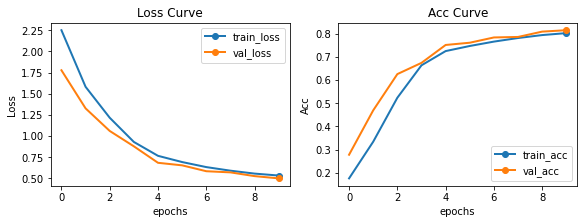

[Info] Saving the model at /content/drive/Othercomputers/My PC/drive/models/2023-02-05/NiNWithOne-061712.pth


In [41]:
nin_with_one_trainer.fit(nin_with_one,data)

### 1x1 conv with three layer

In [42]:
def set_seed():
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

In [43]:
@dataclass(eq=False)
class NiNWithThree(helper.Classifier):
    """
    Output channel number is taken from the sequence [A133572 Row sums of triangle A133571]
    1, 4, 6, 16, 24, 64, 96, 256, 384, 1024......
    refer : https://oeis.org/A133572
    """
    lr:int = 0.01
    num_classes:int = 10
    

    def __post_init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.nin_block(96,11,4,0),
            nn.MaxPool2d(kernel_size=3,stride=2),
            self.nin_block(256,kernel=5,stride=1,padding=2),
            nn.MaxPool2d(kernel_size=3,stride=2),
            self.nin_block(384,3,1,2),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Dropout(0.5),
            self.nin_block(self.num_classes,kernel=3,stride=1,padding=1),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
        )

    @staticmethod
    def nin_block(out_channels,kernel,stride,padding):
        return nn.Sequential(
            nn.LazyConv2d(out_channels,kernel_size=kernel,stride=stride,padding=padding),nn.ReLU(),
            #? modified to have three 1x1 conv
            nn.LazyConv2d(out_channels,kernel_size=1),nn.ReLU(),
            nn.LazyConv2d(out_channels,kernel_size=1),nn.ReLU(),
            nn.LazyConv2d(out_channels,kernel_size=1),nn.ReLU()
        )

    @staticmethod
    def init_nin(module):
        if isinstance(module,(nn.Linear,nn.Conv2d)):
            nn.init.kaiming_normal_(module.weight)

In [44]:
nin_with_three = NiNWithThree().to(device)
nin_with_three.apply_init([next(iter(data.train_dataloader()))[0].to(device)],nin_with_three.init_nin)

In [45]:
torchinfo.summary(nin_with_three,input_size=(1,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
NiNWithThree                             [10, 1]                   --
├─Sequential: 1-1                        [10, 1]                   --
│    └─Sequential: 2-1                   [96, 54, 54]              --
│    │    └─Conv2d: 3-1                  [96, 54, 54]              11,712
│    │    └─ReLU: 3-2                    [96, 54, 54]              --
│    │    └─Conv2d: 3-3                  [96, 54, 54]              9,312
│    │    └─ReLU: 3-4                    [96, 54, 54]              --
│    │    └─Conv2d: 3-5                  [96, 54, 54]              9,312
│    │    └─ReLU: 3-6                    [96, 54, 54]              --
│    │    └─Conv2d: 3-7                  [96, 54, 54]              9,312
│    │    └─ReLU: 3-8                    [96, 54, 54]              --
│    └─MaxPool2d: 2-2                    [96, 26, 26]              --
│    └─Sequential: 2-3                   [256, 26, 26]             --
│ 

In [46]:
nin_with_three_trainer = helper.Trainer(max_epochs=10,model_save_path=MODEL_SAVE_PATH)

Training the model in cuda


  0%|          | 0/10 [00:00<?, ?it/s]

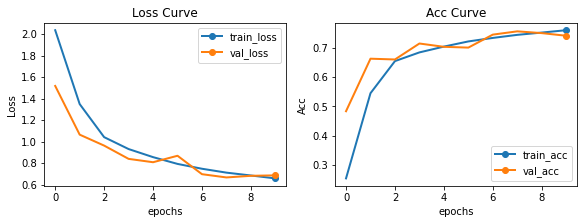

[Info] Saving the model at /content/drive/Othercomputers/My PC/drive/models/2023-02-05/NiNWithThree-063210.pth


In [47]:
nin_with_three_trainer.fit(nin_with_three,data)